## Installing Dependencies


In [ ]:
!pip3 install visdom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 29.3 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=24311a07e98aabd07dc4eceb2880e942a1f5247324f857800389c341c9536bfc
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=5d37787ede55b3de93d56de57df88e3c7b157450f6a4fb78ac82607ce60a9991
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built visdom torchfile


## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/DeepLabV3Plus-Pytorch

/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch


## Importing Libraries

In [ ]:
from tqdm import tqdm
import network
import utils
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np

from torch.utils import data
from datasets import VOCSegmentation, Cityscapes
from utils import ext_transforms as et
from metrics import StreamSegMetrics

import torch
import torch.nn as nn
# from utils.visualizer import Visualizer
from network.backbone import mobilenetv2
from network.utils import IntermediateLayerGetter
from network._deeplab import DeepLabHead, DeepLabHeadV3Plus, DeepLabV3



from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from torchvision import transforms as T

# Defining variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_classes = 21
dataset = 'voc'
random_seed = 1
crop_val = False
crop_size = 513
data_root = "datasets/voc"
batch_size = 4
output_stride = 16
model_name= 'deeplabv3plus_mobilenet'
separable_conv = False
lr = 0.01
weight_decay = 1e-4
lr_policy = 'poly'
total_itrs = 10000
loss_type = 'cross_entropy'
continue_training = False
vis_num_samples = 8
enable_vis = False
test_only = False
val_interval = 100
parent_dir = "/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch"
ckpt = parent_dir + "/checkpoints/best_deeplabv3plus_mobilenet_voc_os16.pth"
pretrained_model_path = parent_dir + "/checkpoints"
imgs_path = parent_dir + "/datasets/voc/VOCdevkit/VOC2012/JPEGImages"

## Defining Helper Functions

In [ ]:
def get_dataset(dataset, crop_size, data_root, crop_val):

    """ Dataset And Augmentation
    """
    if dataset == 'voc':
        train_transform = et.ExtCompose([
            # et.ExtResize(size=opts.crop_size),
            et.ExtRandomScale((0.5, 2.0)),
            et.ExtRandomCrop(size=(crop_size, crop_size), pad_if_needed=True),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
        if crop_val:
            val_transform = et.ExtCompose([
                et.ExtResize(crop_size),
                et.ExtCenterCrop(crop_size),
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            val_transform = et.ExtCompose([
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])


        path = os.path.join(parent_dir, data_root)
        
        if os.path.exists(path) is True:
            print('Already downloaded')
            downloading = False
        else:
          print("Downloading Dataset")
          downloading = True
           
        train_dst = VOCSegmentation(root= data_root, year='2012',
                                  image_set='train', download=downloading, transform=train_transform)
        val_dst = VOCSegmentation(root=data_root, year='2012',
                                   image_set='val', download=False, transform=val_transform)
          


        return train_dst, val_dst

        
def validate( model_name, loader, device, metrics, ret_samples_ids=None):
    """Do validation and return specified samples"""
    metrics.reset()
    ret_samples = []
    # if opts.save_val_results:
    if not os.path.exists('results'):
        os.mkdir('results')
    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img_id = 0

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader)):

            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()

            metrics.update(targets, preds)
            if ret_samples_ids is not None and i in ret_samples_ids:  # get vis samples
                ret_samples.append(
                    (images[0].detach().cpu().numpy(), targets[0], preds[0]))

            # if opts.save_val_results:
            print("number of validation images = ",len(images))
            for i in range(len(images)):
                image = images[i].detach().cpu().numpy()
                target = targets[i]
                pred = preds[i]

                image = (denorm(image) * 255).transpose(1, 2, 0).astype(np.uint8)
                target = loader.dataset.decode_target(target).astype(np.uint8)
                pred = loader.dataset.decode_target(pred).astype(np.uint8)

                Image.fromarray(image).save('results/%d_image.png' % img_id)
                Image.fromarray(target).save('results/%d_target.png' % img_id)
                Image.fromarray(pred).save('results/%d_pred.png' % img_id)

                fig = plt.figure()
                plt.imshow(image)
                plt.axis('off')
                plt.imshow(pred, alpha=0.7)
                ax = plt.gca()
                ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
                ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
                plt.savefig('results/%d_overlay.png' % img_id, bbox_inches='tight', pad_inches=0)
                plt.close()
                img_id += 1

        score = metrics.get_results()
    return score, ret_samples

## Defining Deeplabv3+ 

In [ ]:
def _segm_mobilenet(name, backbone_name, num_classes, output_stride, pretrained_backbone):
    if output_stride==8:
        aspp_dilate = [12, 24, 36]
    else:
        aspp_dilate = [6, 12, 18]

    backbone = mobilenetv2.mobilenet_v2(pretrained=pretrained_backbone, output_stride=output_stride)
    
    # rename layers
    backbone.low_level_features = backbone.features[0:4]
    backbone.high_level_features = backbone.features[4:-1]
    backbone.features = None
    backbone.classifier = None

    inplanes = 320
    low_level_planes = 24
    
    if name=='deeplabv3plus':
        return_layers = {'high_level_features': 'out', 'low_level_features': 'low_level'}
        classifier = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes, aspp_dilate)
    elif name=='deeplabv3':
        return_layers = {'high_level_features': 'out'}
        classifier = DeepLabHead(inplanes , num_classes, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier)
    return model

def _load_model(arch_type, backbone, num_classes, output_stride, pretrained_backbone):

    if backbone=='mobilenetv2':
        model = _segm_mobilenet(arch_type, backbone, num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)
    
    else:
        raise NotImplementedError
    return model


def deeplabv3plus_mobilenet(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3+ model with a MobileNetv2 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3plus', 'mobilenetv2', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)    

## Downloading Dataset

In [ ]:
#Extrating of image may take few minutes after VOC dataset is downloaded

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)

# Setup random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Setup dataloader
if dataset == 'voc' and not crop_val:
    val_batch_size = 1

train_dst, val_dst = get_dataset(dataset, crop_size, data_root, crop_val)
train_loader = data.DataLoader(
    train_dst, batch_size=batch_size, shuffle=True, num_workers=2,
    drop_last=True)  # drop_last=True to ignore single-image batches.
val_loader = data.DataLoader(
    val_dst, batch_size = 1, shuffle=True, num_workers=2)
print("Dataset: %s, Train set: %d, Val set: %d" %
      ('voc', len(train_dst), len(val_dst)))

# Set up model (all models are 'constructed at network.modeling)
model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
if separable_conv and 'plus' in model_name:
    network.convert_to_separable_conv(model.classifier)
utils.set_bn_momentum(model.backbone, momentum=0.01)

# Set up metrics
metrics = StreamSegMetrics(num_classes)

# Set up optimizer
optimizer = torch.optim.SGD(params=[
    {'params': model.backbone.parameters(), 'lr': 0.1 * lr},
    {'params': model.classifier.parameters(), 'lr': lr},
], lr=lr, momentum=0.9, weight_decay=weight_decay)

scheduler = utils.PolyLR(optimizer, total_itrs, power=0.9)

criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

Device: cuda


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Dataset: voc, Train set: 1464, Val set: 1449


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

NOTE : Loading model more than one time may cause runtime errors.
Restart Runtime and run again the whole code to avoid loading error

## Downloading Pretrained Model

In [ ]:
if os.path.exists(pretrained_model_path) is False:
  print("Downloading pretrained model")
  os.makedirs(pretrained_model_path, exist_ok=True) 
  !wget https://drive.google.com/uc?id=1Tk14grO2rl7T5oYzdZA4nd3GTRiLVWTT -O /content/gdrive/MyDrive/DeepLabV3Plus-Pytorch/checkpoints/best_deeplabv3plus_mobilenet_voc_os16.pth

else:
  print("Pretrained model already downloaded") 


def save_ckpt(path):
    """ save current model
    """
    torch.save({
        "cur_itrs": cur_itrs,
        "model_state": model.module.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_score": best_score,
    }, path)
    print("Model saved as %s" % path)

# utils.mkdir('checkpoints')
# Restore
best_score = 0.0
cur_itrs = 0
cur_epochs = 0
if ckpt is not None and os.path.isfile(ckpt):
    # https://github.com/VainF/DeepLabV3Plus-Pytorch/issues/8#issuecomment-605601402, @PytaichukBohdan
    checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    if continue_training:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        cur_itrs = checkpoint["cur_itrs"]
        best_score = checkpoint['best_score']
        print("Training state restored from %s" % ckpt)
    print("Model restored from %s" % ckpt)
    del checkpoint  # free memory
else:
    model = nn.DataParallel(model)
    model.to(device)

# ==========   Train Loop   ==========#
vis_sample_id = np.random.randint(0, len(val_loader), vis_num_samples,
                                  np.int32) if enable_vis else None  # sample idxs for visualization
denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # denormalization for ori images

with torch.no_grad():
        model = model.eval()

--2022-07-20 05:57:37--  https://drive.google.com/uc?id=1Tk14grO2rl7T5oYzdZA4nd3GTRiLVWTT
Resolving drive.google.com (drive.google.com)... 172.217.194.139, 172.217.194.113, 172.217.194.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qmej8ll412sk4ag8138dcctln054qn9r/1658296650000/18391904276917710292/*/1Tk14grO2rl7T5oYzdZA4nd3GTRiLVWTT?uuid=76bfeb07-e7b2-427e-82db-26dbf7fd5e00 [following]
--2022-07-20 05:57:39--  https://doc-14-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qmej8ll412sk4ag8138dcctln054qn9r/1658296650000/18391904276917710292/*/1Tk14grO2rl7T5oYzdZA4nd3GTRiLVWTT?uuid=76bfeb07-e7b2-427e-82db-26dbf7fd5e00
Resolving doc-14-0c-docs.googleusercontent.com (doc-14-0c-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to d

# Training

In [ ]:
interval_loss = 0
while True:  # cur_itrs < opts.total_itrs:
    # =====  Train  =====
    model.train()
    cur_epochs += 1
    for (images, labels) in train_loader:
        cur_itrs += 1

        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        np_loss = loss.detach().cpu().numpy()
        interval_loss += np_loss
        # if vis is not None:
        #     vis.vis_scalar('Loss', cur_itrs, np_loss)

        if (cur_itrs) % 10 == 0:
            interval_loss = interval_loss / 10
            print("Epoch %d, Itrs %d/%d, Loss=%f" %
                  (cur_epochs, cur_itrs, total_itrs, interval_loss))
            interval_loss = 0.0

        if (cur_itrs) % val_interval == 0:
            save_ckpt('checkpoints/latest_%s_%s_os%d.pth' %
                      (model_name, dataset, output_stride))
            print("validation...")
            model.eval()
            val_score, ret_samples = validate(
                 model=model, loader=val_loader, device=device, metrics=metrics,
                ret_samples_ids=vis_sample_id)
            print(metrics.to_str(val_score))
            if val_score['Mean IoU'] > best_score:  # save best model
                best_score = val_score['Mean IoU']
                save_ckpt('checkpoints/best_%s_%s_os%d.pth' %
                          (model_name, dataset, output_stride))

            model.train()
        scheduler.step()

        if cur_itrs >= total_itrs:
          break

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Epoch 1, Itrs 10/10000, Loss=0.254113
Epoch 1, Itrs 20/10000, Loss=0.207697


KeyboardInterrupt: ignored

# Inference

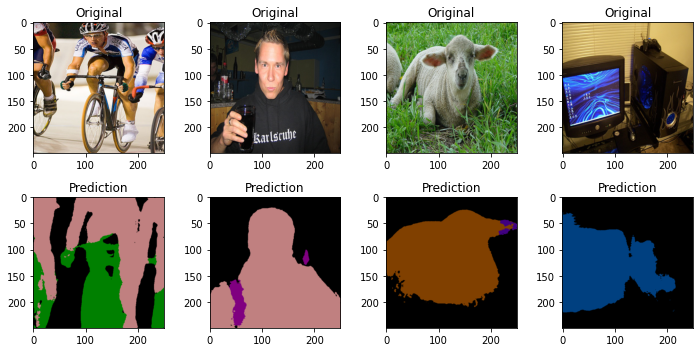

In [ ]:
#Takes 5 pictures from VOC Dataset
transform = T.Compose([
                T.Resize(crop_size),
                T.CenterCrop(crop_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
#For VOC only
decode_fn = VOCSegmentation.decode_target   
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

i = 1
j = 5
for img_name in os.listdir(imgs_path)[10:14]:

  color_img = Image.open(imgs_path+'/'+img_name).convert('RGB')
  img = transform(color_img).unsqueeze(0) # To tensor of NCHW
  img = img.to(device)
  
  pred = model(img).max(1)[1].cpu().numpy()[0] # HW
  colorized_preds = decode_fn(pred).astype('uint8')
  colorized_preds = Image.fromarray(colorized_preds)
  colorized_preds=colorized_preds.resize((250,250))
  # plt.title('original')
  plt.subplot(2,4,i)
  plt.imshow(color_img.resize((250,250)))
  #prediction
  plt.title('Original')
  plt.subplot(2,4,j)
  plt.imshow(colorized_preds)
  plt.title('Prediction')
  i+=1
  j+=1

